<a href="https://colab.research.google.com/github/Hoang-it/orhcid_classification/blob/main/sof/sof_pspnet_r50-d8_512x1024_40k_cityscapes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.8.0/index.html

!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████▌                  | 834.1 MB 1.3 MB/s eta 0:14:31tcmalloc: large alloc 1147494400 bytes == 0x55f7a5f3a000 @  0x7f683076b615 0x55f76bc024cc 0x55f76bce247a 0x55f76bc052ed 0x55f76bcf6e1d 0x55f76bc78e99 0x55f76bc739ee 0x55f76bc06bda 0x55f76bc78d00 0x55f76bc739ee 0x55f76bc06bda 0x55f76bc75737 0x55f76bcf7c66 0x55f76bc74daf 0x55f76bcf7c66 0x55f76bc74daf 0x55f76bcf7c66 0x55f76bc74daf 0x55f76bc07039 0x55f76bc4a409 0x55f76bc05c52 0x55f76bc78c25 0x55f76bc739ee 0x55f76bc06bda 0x55f76bc75737 0x55f76bc739ee 0x55f76bc06bda 0x55f76bc74915 0x55f76bc06afa 0x55f76bc74c0d 0x55f76bc739ee
     |█████████████████               | 1055.7 MB 1.2 MB/s eta 0:13:00tcmalloc: large alloc 1434370048 bytes == 0x55f7ea590000 @  0x7f683076b615 0x55f76bc024cc 0x55f76bce247a 0x55f76bc052ed 0x55f76bcf6e1d 0x55f76bc78e99 0x55f76bc739ee 0x55f76bc06bda 0x55f76bc78d00 0x55f76bc739ee 0x55f76bc06bda 0x55f76bc75737 0x55f76bcf7c66 0x55f76bc74d

In [2]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.8.0+cu111 True
0.17.0


In [3]:
!mkdir checkpoints
!gdown --id 1qsaRBG-IbHJVTsXAZUK3-X66d95mY8Dr

Downloading...
From: https://drive.google.com/uc?id=1qsaRBG-IbHJVTsXAZUK3-X66d95mY8Dr
To: /content/mmsegmentation/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
196MB [00:01, 111MB/s] 


In [4]:
!mv /content/mmsegmentation/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth /content/mmsegmentation/checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth

In [5]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

config_file = 'configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py'
checkpoint_file = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

In [6]:
%cd mmsegmentation
!gdown --id 1RiRLglta9IewrR8Y7wqx8ZtDmdUSNi8M 

[Errno 2] No such file or directory: 'mmsegmentation'
/content/mmsegmentation
Downloading...
From: https://drive.google.com/uc?id=1RiRLglta9IewrR8Y7wqx8ZtDmdUSNi8M
To: /content/mmsegmentation/18092021_dataset.zip
4.23MB [00:00, 37.2MB/s]


In [7]:
!mkdir dataset
!unzip /content/mmsegmentation/18092021_dataset.zip -d dataset

Archive:  /content/mmsegmentation/18092021_dataset.zip
 extracting: dataset/images/25.jpg   
 extracting: dataset/images/69.jpg   
 extracting: dataset/images/70.jpg   
 extracting: dataset/images/73.jpg   
 extracting: dataset/images/66.jpg   
 extracting: dataset/images/29.jpg   
 extracting: dataset/images/84.jpg   
 extracting: dataset/images/26.jpg   
 extracting: dataset/images/74.jpg   
 extracting: dataset/images/32.jpg   
 extracting: dataset/images/91.jpg   
 extracting: dataset/images/76.jpg   
 extracting: dataset/images/48.jpg   
 extracting: dataset/images/37.jpg   
 extracting: dataset/images/71.jpg   
 extracting: dataset/images/22.jpg   
 extracting: dataset/images/99.jpg   
 extracting: dataset/images/62.jpg   
 extracting: dataset/images/27.jpg   
 extracting: dataset/images/96.jpg   
 extracting: dataset/images/39.jpg   
 extracting: dataset/images/77.jpg   
 extracting: dataset/images/46.jpg   
 extracting: dataset/images/31.jpg   
 extracting: dataset/images/34.jp

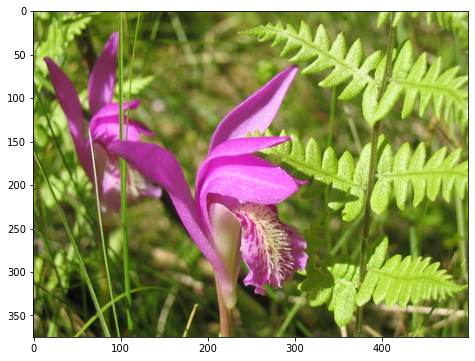

In [8]:
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('/content/mmsegmentation/dataset/images/100.jpg')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [9]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import os
import cv2
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## For visualizing results
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

dataDir='/content/mmsegmentation/dataset'
dataType='default'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
labels_dir = '/content/mmsegmentation/dataset/labels'


if os.path.exists(labels_dir):
  files = glob.glob(labels_dir + '/*')
  for f in files:
      os.remove(f)
else:
  try:
      os.makedirs(labels_dir, exist_ok = True)
      print("Directory '%s' created successfully" %labels_dir)
  except OSError as error:
      print("Directory '%s' can not be created")

# initialize the COCO api for instance annotations
coco=COCO(annFile)

def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

# get all images containing given categories, select one at random
filterClasses = ['orchid']
catIds = coco.getCatIds(catNms=filterClasses)
imgIds = coco.getImgIds(catIds=catIds)
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)
len_imgs = len(imgIds)
print("Number of images containing all required classes:", len(imgIds))
      
exception_files = []

input_img_paths = []
target_img_paths = []

for imgId in range(len_imgs):
  img = coco.loadImgs(imgIds[imgId])[0]
  file_name = img['file_name']
  file_path = '{}/images/{}'.format(dataDir, file_name)
  save = True

  # I = io.imread('{}/images/{}/{}'.format(dataDir, dataType, file_name))/255.0
  I = io.imread(file_path)/255.0

  annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
  anns = coco.loadAnns(annIds)
  # coco.showAnns(anns)

  mask = np.zeros((img['height'],img['width']))


  for i in range(len(anns)):
      className = getClassName(anns[i]['category_id'], cats)
      pixel_value = filterClasses.index(className)+1
      try:          
        mask = np.maximum(coco.annToMask(anns[i])*pixel_value, mask)      
        
      except:
        print("An exception occurred with file : {}".format(file_name))
        exception_files.append('/content/mmsegmentation/dataset/images/' + file_name)
        save = False
  if save:
    mask_path = '{}/{}.regions'.format(labels_dir, file_name.split('.')[0])
    np.savetxt(mask_path, mask, fmt='%d', delimiter=' ')
    input_img_paths.append(file_path)
    target_img_paths.append(mask_path)

Directory '/content/mmsegmentation/dataset/labels' created successfully
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of images containing all required classes: 80


In [10]:
import os.path as osp
import numpy as np
from PIL import Image
# convert dataset annotation to semantic segmentation map
data_root = '/content/mmsegmentation/dataset'
img_dir = 'images'
ann_dir = 'labels'
# define class and plaette for better visualization
classes = ('background', 'orchid')
palette = [[128, 128, 128], [129, 127, 38]]
for file in mmcv.scandir(osp.join(data_root, ann_dir), suffix='.regions'):
  seg_map = np.loadtxt(osp.join(data_root, ann_dir, file)).astype(np.uint8)
  seg_img = Image.fromarray(seg_map).convert('P')
  seg_img.putpalette(np.array(palette, dtype=np.uint8))
  seg_img.save(osp.join(data_root, ann_dir, file.replace('.regions', 
                                                         '.png')))

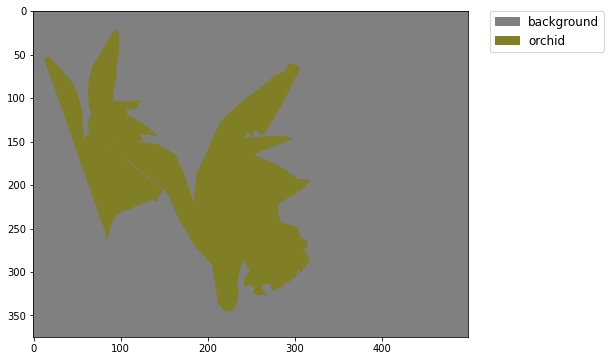

In [11]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
img = Image.open('/content/mmsegmentation/dataset/labels/100.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(len(classes))]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [12]:
# split train/val set randomly
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

In [13]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class OrchidDataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

    

In [14]:
from mmcv import Config
cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py')

In [15]:
from mmseg.apis import set_random_seed

# Since we use ony one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 2
cfg.model.auxiliary_head.num_classes = 2

# Modify dataset type and path
cfg.dataset_type = 'OrchidDataset'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu=8

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(320, 240),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 200
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 200

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        pool_scales=(1, 2, 3, 6),
        dropout_ratio=0.1,
        num_classes=2,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,
        in_index=2,
        channels=256,
        num_convs=1,
        concat_input=F

In [16]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

/usr/local/lib/python3.7/dist-packages/mmcv/utils/misc.py:324: UserWarning: "flip_ratio" is deprecated in `RandomFlip.__init__`, please use "prob" instead
  f'"{src_arg_name}" is deprecated in '
2021-09-27 18:25:29,727 - mmseg - INFO - Loaded 64 images
/content/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
2021-09-27 18:25:35,156 - mmseg - INFO - Loaded 16 images
2021-09-27 18

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 16/16, 16.9 task/s, elapsed: 1s, ETA:     0s

2021-09-27 18:26:56,034 - mmseg - INFO - per class results:
2021-09-27 18:26:56,036 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.29 | 98.82 |
|   orchid   | 84.86 | 90.75 |
+------------+-------+-------+
2021-09-27 18:26:56,037 - mmseg - INFO - Summary:
2021-09-27 18:26:56,038 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.65 | 91.08 | 94.78 |
+-------+-------+-------+
2021-09-27 18:26:56,040 - mmseg - INFO - Iter(val) [16]	aAcc: 0.9765, mIoU: 0.9108, mAcc: 0.9478, IoU.background: 0.9729, IoU.orchid: 0.8486, Acc.background: 0.9882, Acc.orchid: 0.9075


/content/mmsegmentation/mmseg/models/segmentors/base.py:264: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

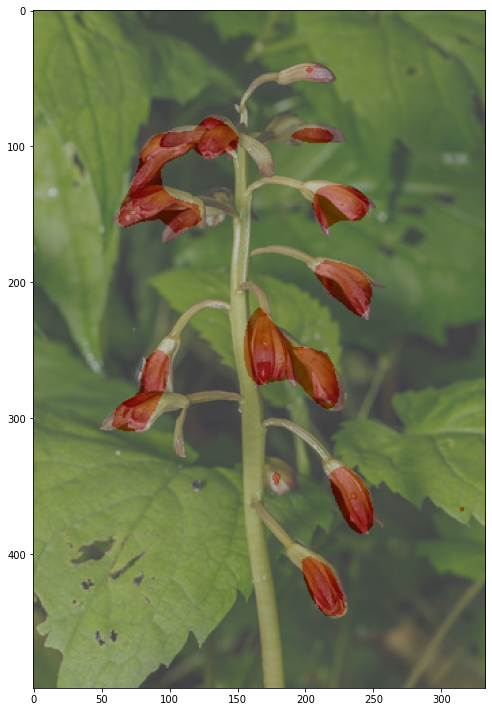

In [17]:
img = mmcv.imread('/content/mmsegmentation/dataset/images/37.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
palette = [[128, 128, 128], [128,0,0]]
show_result_pyplot(model, img, result, palette)

In [18]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [24]:
train_folder = '/gdrive/MyDrive/KLTN/dataset/OCD_Harvard/Species_Classifier/train'
test_folder = '/gdrive/MyDrive/KLTN/dataset/OCD_Harvard/Species_Classifier/test'
val_folder = '/gdrive/MyDrive/KLTN/dataset/OCD_Harvard/Species_Classifier/val'

/content/mmsegmentation/mmseg/models/segmentors/base.py:264: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

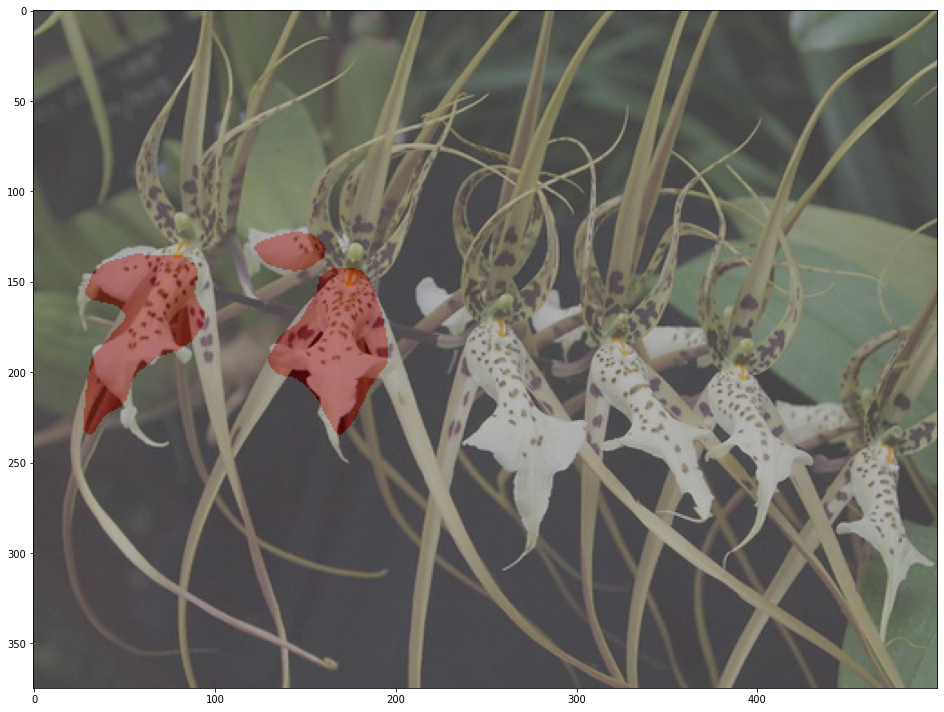

In [28]:
img = mmcv.imread('/gdrive/MyDrive/KLTN/dataset/OCD_Harvard/Species_Classifier/test/6/170.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
palette = [[128, 128, 128], [128,0,0]]
show_result_pyplot(model, img, result, palette)

In [33]:
result[0].shape[0]

375

In [31]:
img.shape

(375, 500, 3)

In [32]:
np.unique(result[0], return_counts=True)

(array([0, 1]), array([179652,   7848]))

In [35]:
for i in range(result[0].shape[0]):
  for j in range(result[0].shape[1]):
    if result[0][i][j] == 0:
      img[i][j] = [0, 0, 0]

In [37]:
type(img)

numpy.ndarray

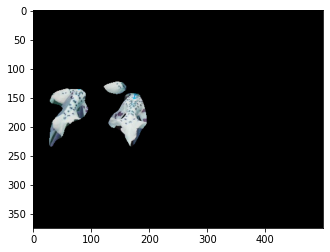

In [38]:
# %pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# img = mpimg.imread('your_image.png')
imgplot = plt.imshow(img)
plt.show()

In [40]:
import cv2
cv2.imwrite('out.jpg', img)

True

In [46]:
import glob
name_classes = glob.glob(train_folder + '/*')

print(glob.glob(name_classes[0] + '/*'))

['/gdrive/MyDrive/KLTN/dataset/OCD_Harvard/Species_Classifier/train/50/2775.jpg', '/gdrive/MyDrive/KLTN/dataset/OCD_Harvard/Species_Classifier/train/50/2822.jpg', '/gdrive/MyDrive/KLTN/dataset/OCD_Harvard/Species_Classifier/train/50/2854.jpg', '/gdrive/MyDrive/KLTN/dataset/OCD_Harvard/Species_Classifier/train/50/2804.jpg', '/gdrive/MyDrive/KLTN/dataset/OCD_Harvard/Species_Classifier/train/50/2858.jpg', '/gdrive/MyDrive/KLTN/dataset/OCD_Harvard/Species_Classifier/train/50/2850.jpg', '/gdrive/MyDrive/KLTN/dataset/OCD_Harvard/Species_Classifier/train/50/2778.jpg', '/gdrive/MyDrive/KLTN/dataset/OCD_Harvard/Species_Classifier/train/50/2863.jpg', '/gdrive/MyDrive/KLTN/dataset/OCD_Harvard/Species_Classifier/train/50/2835.jpg', '/gdrive/MyDrive/KLTN/dataset/OCD_Harvard/Species_Classifier/train/50/2846.jpg', '/gdrive/MyDrive/KLTN/dataset/OCD_Harvard/Species_Classifier/train/50/2777.jpg', '/gdrive/MyDrive/KLTN/dataset/OCD_Harvard/Species_Classifier/train/50/2856.jpg', '/gdrive/MyDrive/KLTN/datas

In [47]:
newfoler_test = '/gdrive/MyDrive/KLTN/dataset/OCD_Harvard/MyData/test'
newfoler_train = '/gdrive/MyDrive/KLTN/dataset/OCD_Harvard/MyData/train'
newfoler_val = '/gdrive/MyDrive/KLTN/dataset/OCD_Harvard/MyData/val'

In [57]:
import glob
import os

name_classes = glob.glob(train_folder + '/*')
for name_class in name_classes:
  class_name = name_class.split('/')[-1]
  if not os.path.exists(newfoler_train + '/' + class_name):
    os.mkdir(newfoler_train + '/' + class_name)

  images = glob.glob(name_class + '/*')

  for img_path in images:
    img_name = img_path.split('/')[-1]

    img = mmcv.imread(img_path)

    model.cfg = cfg
    result = inference_segmentor(model, img)

    for i in range(result[0].shape[0]):
      for j in range(result[0].shape[1]):
        if result[0][i][j] == 0:
          img[i][j] = [0, 0, 0]
    try:
      cv2.imwrite(newfoler_train + '/' + class_name + '/' + img_name, img)
    except:
      print(newfoler_train + '/' + class_name + '/' + img_name)

In [58]:
import glob
import os

name_classes = glob.glob(test_folder + '/*')
for name_class in name_classes:
  class_name = name_class.split('/')[-1]
  if not os.path.exists(newfoler_test + '/' + class_name):
    os.mkdir(newfoler_test + '/' + class_name)

  images = glob.glob(name_class + '/*')

  for img_path in images:
    img_name = img_path.split('/')[-1]

    img = mmcv.imread(img_path)

    model.cfg = cfg
    result = inference_segmentor(model, img)

    for i in range(result[0].shape[0]):
      for j in range(result[0].shape[1]):
        if result[0][i][j] == 0:
          img[i][j] = [0, 0, 0]
    try:
      cv2.imwrite(newfoler_test + '/' + class_name + '/' + img_name, img)
    except:
      print(newfoler_test + '/' + class_name + '/' + img_name)
  print('Class {} done'.format(class_name))

Class 140 done
Class 27 done
Class 98 done
Class 50 done
Class 76 done
Class 151 done
Class 129 done
Class 85 done
Class 9 done
Class 84 done
Class 149 done
Class 147 done
Class 135 done
Class 49 done
Class 15 done
Class 43 done
Class 36 done
Class 89 done
Class 16 done
Class 90 done
Class 110 done
Class 31 done
Class 21 done
Class 115 done
Class 24 done
Class 80 done
Class 55 done
Class 75 done
Class 37 done
Class 68 done
Class 5 done
Class 130 done
Class 34 done
Class 141 done
Class 118 done
Class 133 done
Class 45 done
Class 60 done
Class 12 done
Class 91 done
Class 8 done
Class 94 done
Class 121 done
Class 100 done
Class 53 done
Class 127 done
Class 67 done
Class 78 done
Class 132 done
Class 29 done
Class 1 done
Class 134 done
Class 22 done
Class 117 done
Class 25 done
Class 86 done
Class 17 done
Class 109 done
Class 146 done
Class 96 done
Class 30 done
Class 119 done
Class 87 done
Class 79 done
Class 83 done
Class 113 done
Class 103 done
Class 13 done
Class 65 done
Class 72 done
C

In [59]:
import glob
import os

name_classes = glob.glob(val_folder + '/*')
for name_class in name_classes:
  class_name = name_class.split('/')[-1]
  if not os.path.exists(newfoler_val + '/' + class_name):
    os.mkdir(newfoler_val + '/' + class_name)

  images = glob.glob(name_class + '/*')

  for img_path in images:
    img_name = img_path.split('/')[-1]

    img = mmcv.imread(img_path)

    model.cfg = cfg
    result = inference_segmentor(model, img)

    for i in range(result[0].shape[0]):
      for j in range(result[0].shape[1]):
        if result[0][i][j] == 0:
          img[i][j] = [0, 0, 0]
    try:
      cv2.imwrite(newfoler_val + '/' + class_name + '/' + img_name, img)
    except:
      print(newfoler_val + '/' + class_name + '/' + img_name)
  print('Class {} done'.format(class_name))